# Proyecto final Machine Learning

Jorge Ruizvisfocri

Emilio Martinez

# Descripción del proyecto

El siguiente proyecto busca clasificar imágenes de Carcinomas Ductales Invasivos (IDC en inglés) extraidas de muestras de pacientes con cancer de mama.

### Motivación

El carcinoma ductal invasivo (IDC, por sus siglas en inglés) es, con aproximadamente el 80% de los casos, uno de los tipos más comunes de cáncer de mama. Es maligno y capaz de formar metástasis, lo que lo hace especialmente peligroso. A menudo, se realiza una biopsia para extraer pequeñas muestras de tejido. Luego, un patólogo debe decidir si un paciente tiene IDC, otro tipo de cáncer de mama o está sano. Además, es necesario localizar las células enfermas para determinar cuán avanzada está la enfermedad y qué grado debe asignarse. Esto debe hacerse de forma manual y es un proceso que consume mucho tiempo. Además, la decisión depende de la experiencia del patólogo y de su equipo. Por lo tanto, el aprendizaje profundo podría ser de gran ayuda para detectar y localizar automáticamente las células del tejido tumoral y acelerar el proceso. Para aprovechar todo su potencial, se podría construir un flujo de trabajo utilizando grandes cantidades de datos de imágenes de tejidos de diversos hospitales que hayan sido evaluados por diferentes expertos. De esta manera, se podría superar la dependencia del patólogo, lo cual sería especialmente útil en regiones donde no hay expertos disponibles.

La base de datos fue tomada de https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

Se propone utilizar una red neuronal convolucional para resolver el problema de clasificación.

### ¿Qué se entiende por carcinoma ductal invasivo?

El carcinoma ductal invasivo es un tipo de cáncer de mama que se origina en los conductos mamarios. En la ilustración creada por Mikael Häggström se muestra la anatomía de un seno sano. Se pueden observar los lóbulos, que son las glándulas que producen leche, la cual fluye a través de los conductos de la leche. El carcinoma ductal comienza a desarrollarse en los conductos, mientras que el carcinoma lobular tiene su origen en los lóbulos. El carcinoma invasivo tiene la capacidad de salir de su compartimento tisular inicial y puede formar metástasis.

![picTitle](image.png)

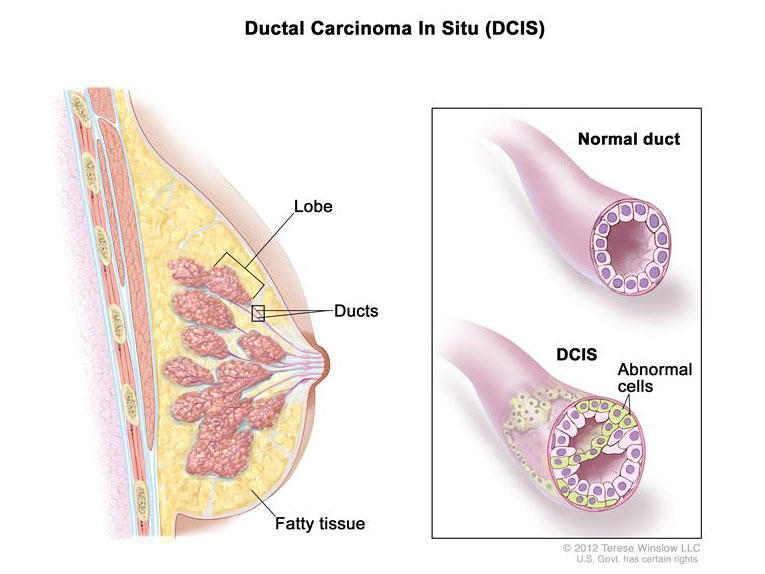

In [1]:
from IPython.display import Image
Image('C:/Users/permi/OneDrive - CIDE/CIDE/4to semestre/ML/final_ml_metpol/image.png')

# Paqueterías de trabajo

In [2]:
## Paquetes de ciencias de datos
import pandas as pd
import numpy as np
from tensorflow import convert_to_tensor
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import math
import random

## Paquetes de lectura de imagenes
from pathlib import Path
import os
import glob

## Paquetes de imágenes
from PIL import Image
import cv2
from skimage.io import imread
##Otros
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import seaborn as sns
from os import listdir
import tensorflow as tflow

# Datos de trabajo

In [3]:
# Directorio de imágenes
data_dir = Path("C:/Users/permi/OneDrive - CIDE/CIDE/4to semestre/ML/imagenes/IDC_regular_ps50_idx5") ## Directorio de datos

# Descripcion de los datos

In [4]:
files = listdir("C:/Users/permi/OneDrive - CIDE/CIDE/4to semestre/ML/imagenes/IDC_regular_ps50_idx5")

In [5]:
folder = listdir(data_dir)
len(folder)

279

In [6]:
base_path = "C:/Users/permi/OneDrive - CIDE/CIDE/4to semestre/ML/imagenes/IDC_regular_ps50_idx5/"
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)
total_images

277524

In [7]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

patient_id                                               path target
0      10253  C:/Users/permi/OneDrive - CIDE/CIDE/4to semest...      0
1      10253  C:/Users/permi/OneDrive - CIDE/CIDE/4to semest...      0
2      10253  C:/Users/permi/OneDrive - CIDE/CIDE/4to semest...      0
3      10253  C:/Users/permi/OneDrive - CIDE/CIDE/4to semest...      0
4      10253  C:/Users/permi/OneDrive - CIDE/CIDE/4to semest...      0

In [8]:
data.target = data.target.astype(int)

In [9]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

## Parches de cáncer

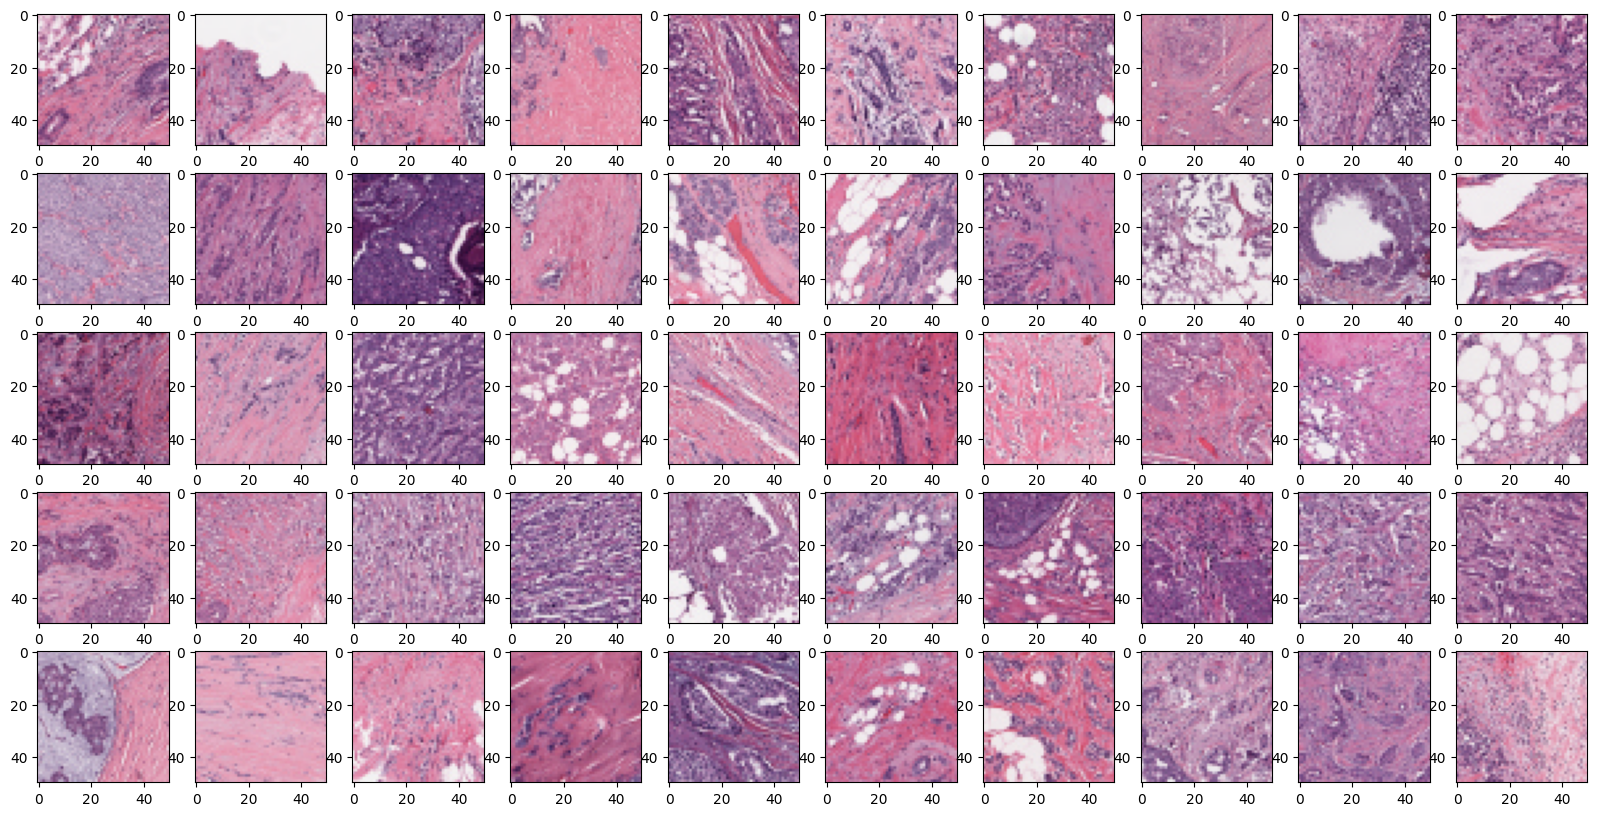

In [10]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

## Parches Sanos

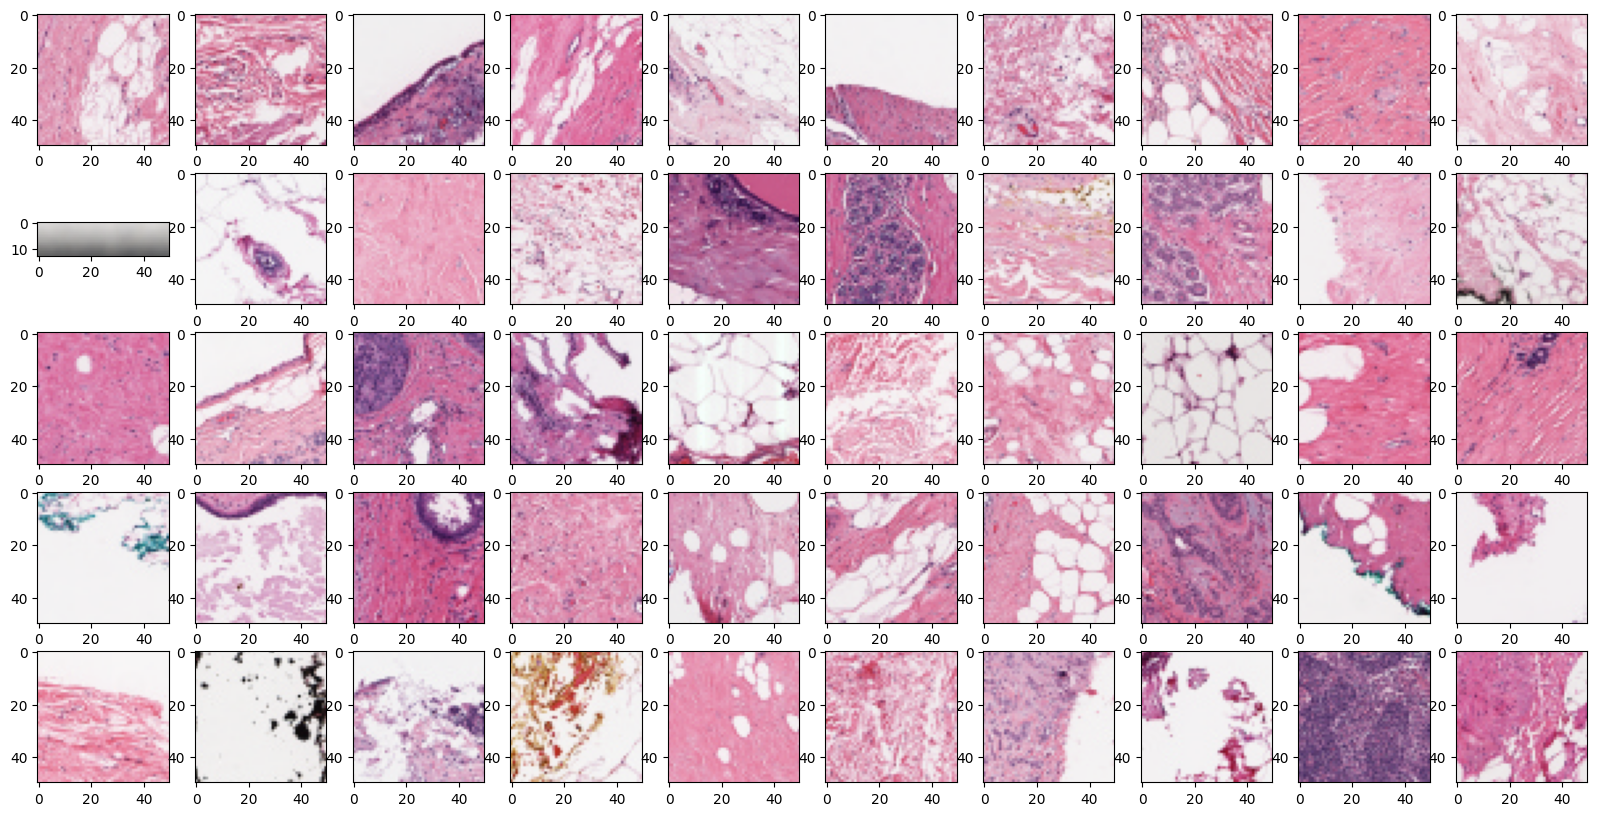

In [11]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

# Preprocesamiento 

Las imágenes de este proyecto corresponden a cuadros tomados de muestras de microscopio de tejido de mama de distintas pacientes con tumores benignos o malignos. Para poder trabajar las imágenes utilizando aprendizaje profundo, tenemos una serie de retos relacionadas con el formato de las imágenes, la selección del conjunto de aprendizaje y el conjunto de prueba.

Los datos están estructurados de la siguiente forma en el directorio de trabajo: Cada paciente cuenta con una carpeta propia, la cual contiene dos subcarpetas (llamadas 1 y 0), las cuales tienen las imágenes de interés. Las imágenes en las carpetas 1 corresponden a tumores malignos, mientras que las imágenes en las carpetas 0 corresponden a tumores benignos.

![alternative text](arquitectura_modelo.jfif)

## Selección del conjunto de aprendizaje y del conjunto de prueba.

Dada la estructura de datos descrita anteriormente, consideramos factible creer que existe un cierto grado de correlación entre las imágenes pertenecientes a un mismo paciente, debido a que pertenecen a una misma muestra de tejido. Por lo tanto, decidimos que para dividir los datos entre conjuntos de entrenamiento y prueba, haríamos una aleatorización inicial a nivel de paciente, con el fin de que la red tenga datos completamente nuevos para probar sus resultados.

Consideramos que esta aleatorización además coincide con una dinámica de la vida real, pues si la red tuviera que realizar nuevas predicciones, los haría sobre imágenes de pacientes que jamás ha visto. Para realizar la aleatorización, primero obtuvimos la lista de pacientes, calculamos el número equivalente al 80% de los pacientes para seleccionar el conjunto de entrenamiento, y realizamos una muestra aleatoria de los pacientes para tener las identidades del conjunto de entrenamiento. El conjunto de prueba fueron los pacientes no seleccionados en el conjunto de entrenamiento.

## Procesamiento de las imágenes.

El preprocesamiento de las imágenes consistió en cargar las imágenes a un objeto numpy, volverla compatible con la red neuronal convolucionada convirtiéndolo en un tensor, y preparar las etiquetas correspondientes a cada imágen.

Para cargar las imágenes, realizamos un ciclo for que extrajo cada imagen en las carpetas de los pacientes y las almacenó en un array numpy. Luego, aplanamos las imágenes dividiéndolas entre 255, lo que permitió "normalizar los colores" presentes en los pixeles, y después convertimos el objeto array en un tensor de dimensiones $(n,w,h,c)$

Las etiquetas las creamos utilizando un ciclo for donde extrajimos si la imagen en cuestión pertenecía a una subcarpeta 1 o 0. Luego, este vector lo convertimos en un array de dimensiones $(n,2)$, donde cada entrada se podía clasificar como $[1,0]$ si no presentaba cancer, o $[0,1]$ si presentaba cancer.

In [12]:
### Aleatorización a nivel de paciente
#### Obtenemos la lista de pacientes
px = [f for f in data_dir.iterdir() if f.is_dir()]

### Obtenemos el número equivalente al porcentaje deseado
k = math.ceil( len(px) * 80 // 100)

### fijamos la semilla para tener reproductibilidad
random.seed(4352)

train_id = random.sample(px,k)

test_id = set(px) - set(train_id)

In [13]:
### Limpieza
del data_dir
del px
del k

In [14]:
### cargamos files de entrenamiento
train_images_files = []
for p in tqdm(train_id):
    img_lst = list(p.rglob("*.png"))
    train_images_files.extend(img_lst)

100%|██████████| 223/223 [00:02<00:00, 75.77it/s] 


In [15]:
test_images_files = []
for p in tqdm(test_id):
    img_lst = list(p.rglob("*.png"))
    test_images_files.extend(img_lst)

100%|██████████| 56/56 [00:00<00:00, 131.09it/s]


In [16]:
### Revisamos que las direcciones de las imágenes estén bien cargadas
print(
    f"Número de imagenes\n"
    "-----------------\n"
    f"Total: {len(train_images_files) + len(test_images_files) }\n"  # 277,524 tiles
    "-----------------\n"
    f"Entrenamiento: {len(train_images_files) }\n"
    "-----------------\n"
    f"Prueba: {len(test_images_files) }\n"
)

Número de imagenes
-----------------
Total: 277524
-----------------
Entrenamiento: 220389
-----------------
Prueba: 57135



In [17]:
### Limpieza
del train_id
del test_id

## Preparamos las etiquetas

In [18]:
## y_entrenamiento
### Preparamos las etiquetas
y_train = []
for name in tqdm(train_images_files):
    etiqueta = str(name)[-5]
    etiqueta_num = int(etiqueta)
    y_train.append(etiqueta_num)
y_train = np.asarray(y_train,dtype=int)

100%|██████████| 220389/220389 [00:00<00:00, 641539.66it/s]


In [19]:
y_test = []
for name in tqdm(test_images_files):
    etiqueta = str(name)[-5]
    etiqueta_num = int(etiqueta)
    y_test.append(etiqueta_num)
y_test = np.asarray(y_test,dtype=int)

100%|██████████| 57135/57135 [00:00<00:00, 635849.65it/s]


In [20]:
### Revisamos números de positivos en conjuntos
print(
    f"Positivos totales\n"
    "-----------------\n"
    f"Total: {sum(y_train) + sum(y_test)}\n"  # 277,524 tiles
    "-----------------\n"
    f"Entrenamiento: {sum(y_train) }\n"
    "-----------------\n"
    f"Prueba: {sum(y_test) }\n"
     "------------------------\n"
    f"Positivos porcentajes\n"
    "-----------------\n"
    f"Total: { round((sum(y_train) + sum(y_test))/ (len(y_train) + len(y_test)),2)  }\n"  # 277,524 tiles
    "-----------------\n"
    f"Entrenamiento: {round(sum(y_train)/ len(y_train),2) }\n"
    "-----------------\n"
    f"Prueba: {round(sum(y_test)/ len(y_test),2) }\n"
)

Positivos totales
-----------------
Total: 78786
-----------------
Entrenamiento: 64466
-----------------
Prueba: 14320
------------------------
Positivos porcentajes
-----------------
Total: 0.28
-----------------
Entrenamiento: 0.29
-----------------
Prueba: 0.25



## Preparamos las imágenes

In [21]:
### Cargamos de imágenes de entrenamiento en una lista
dataset_img_train = list()
for img in tqdm(train_images_files):
    image = Image.open(img)
    image=image.resize((50,50))
    numpydata = np.asarray(image)
    dataset_img_train.append(numpydata)

100%|██████████| 220389/220389 [02:43<00:00, 1349.25it/s]


In [22]:
### Convertimos la lista en tensor
dataset_img_train_array = np.asarray(dataset_img_train,dtype=object)

In [23]:
### Limpieza
del train_images_files
del etiqueta
del etiqueta_num
del dataset_img_train
del numpydata

In [24]:
dataset_img_train_array.shape ## Debe darnos un vector de tamaño (n,a,b,c)

(220389, 50, 50, 3)

In [25]:
### Aplanamos los datos
dataset_img_train_array_plana = dataset_img_train_array.astype('int') / 255 

In [26]:
dataset_img_train_array_plana[0:3] ## Vemos las primeras entradas para verificar que estén aplanados los datos

array([[[[0.89411765, 0.63529412, 0.74117647],
         [0.8627451 , 0.59215686, 0.70588235],
         [0.89019608, 0.57647059, 0.70588235],
         ...,
         [0.9254902 , 0.8       , 0.85882353],
         [0.92156863, 0.76470588, 0.83137255],
         [0.90196078, 0.7372549 , 0.80784314]],

        [[0.85098039, 0.56078431, 0.68235294],
         [0.83921569, 0.51372549, 0.6627451 ],
         [0.81568627, 0.48235294, 0.61176471],
         ...,
         [0.94901961, 0.90196078, 0.91764706],
         [0.94117647, 0.88627451, 0.91372549],
         [0.90196078, 0.71372549, 0.80392157]],

        [[0.89411765, 0.64313725, 0.75294118],
         [0.88235294, 0.62352941, 0.71372549],
         [0.88235294, 0.57647059, 0.71764706],
         ...,
         [0.88627451, 0.65490196, 0.75294118],
         [0.9254902 , 0.76470588, 0.84705882],
         [0.9254902 , 0.79607843, 0.83921569]],

        ...,

        [[0.92156863, 0.79215686, 0.85490196],
         [0.9254902 , 0.80392157, 0.84705882]

In [27]:
del dataset_img_train_array

In [28]:
### Cargamos imágenes de prueba en una lista
dataset_img_test = list()
for img in tqdm(test_images_files):
    image = Image.open(img)
    image=image.resize((50,50))
    numpydata = np.asarray(image)
    dataset_img_test.append(numpydata)

100%|██████████| 57135/57135 [00:40<00:00, 1403.14it/s]


In [29]:
### Convertimos la lista en tensor
dataset_img_test_array = np.asarray(dataset_img_test,dtype=object)

In [30]:
### Limpieza
del test_images_files
del dataset_img_test
del image
del numpydata


In [31]:
dataset_img_test_array.shape ## Debe darnos un vector de tamaño (n,a,b,c)

(57135, 50, 50, 3)

In [32]:
### Aplanamos los datos
dataset_img_test_array_plana = dataset_img_test_array.astype('int') / 255

In [33]:
dataset_img_test_array_plana[0:3] ## Vemos las primeras entradas para verificar que estén aplanados los datos

array([[[[0.94117647, 0.91372549, 0.92941176],
         [0.94509804, 0.92941176, 0.9372549 ],
         [0.94901961, 0.90980392, 0.9254902 ],
         ...,
         [0.80784314, 0.51372549, 0.64705882],
         [0.58823529, 0.37254902, 0.55294118],
         [0.83921569, 0.51764706, 0.64313725]],

        [[0.95686275, 0.92941176, 0.92941176],
         [0.93333333, 0.90980392, 0.91764706],
         [0.94901961, 0.90588235, 0.91764706],
         ...,
         [0.76470588, 0.49803922, 0.64313725],
         [0.38431373, 0.25098039, 0.45490196],
         [0.80392157, 0.5372549 , 0.65882353]],

        [[0.9372549 , 0.90588235, 0.9254902 ],
         [0.95686275, 0.8745098 , 0.89411765],
         [0.83137255, 0.47843137, 0.58431373],
         ...,
         [0.72941176, 0.4745098 , 0.62352941],
         [0.63529412, 0.41176471, 0.57647059],
         [0.87843137, 0.59215686, 0.69803922]],

        ...,

        [[0.92156863, 0.83529412, 0.8745098 ],
         [0.84705882, 0.63921569, 0.74509804]

# Modelo MaRu

## Conjunto de entrenamiento y validación

In [34]:
### Limpiamos ambiente de trabajo
#del dataset_img_train_array_plana
#del y_train

In [35]:
### Creamos conjuntos de validación y entrenamiento
X_train, X_val, y_train, y_val = train_test_split(dataset_img_train_array_plana, y_train, test_size=0.33, random_state=42)

In [36]:
from tensorflow.keras.utils import to_categorical
y_train_tensor = to_categorical(y_train, num_classes = 2)
y_val_tensor = to_categorical(y_val, num_classes = 2)

In [37]:
### Preparamos tensores
x_train_tensor = convert_to_tensor(X_train)
X_val_tensor = convert_to_tensor(X_val)
#y_train_tensor = convert_to_tensor(y_train)
#y_val_tensor = convert_to_tensor(y_val)



In [38]:
y_train_tensor

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [39]:
### Limpieza
del X_train
del X_val
del y_train
del y_val


## Arquitectura del modelo MaRu

In [40]:
### Usamos modelo de la tarea 11
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
#model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [41]:

from tensorflow.keras.callbacks import LearningRateScheduler

## Función de learning rate
def scheduler_1(epoch, lr):
    l = 0.01
    if epoch>3:
        l = 0.001
    if epoch>7:
        l = 0.0001
    if epoch>10:
        l = 0.00001    
    return l

callback = LearningRateScheduler(scheduler_1, verbose=1)

In [42]:
model.compile(optimizer=keras.optimizers.Adadelta(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                    

## Entrenamiento del modelo MaRu

In [44]:
## Entrenamos el modelo
history = model.fit(x_train_tensor, y_train_tensor,
                    batch_size=128,
                    epochs=12,
                    validation_data=(X_val_tensor, y_val_tensor),
                    shuffle=True,
                    callbacks=[callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/12
1154/1154 [==============================] - 270s 231ms/step - loss: 0.4978 - accuracy: 0.7567 - val_loss: 0.4296 - val_accuracy: 0.8036 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/12
1154/1154 [==============================] - 250s 217ms/step - loss: 0.4131 - accuracy: 0.8175 - val_loss: 0.4196 - val_accuracy: 0.8160 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/12
1154/1154 [==============================] - 214s 186ms/step - loss: 0.4021 - accuracy: 0.8251 - val_loss: 0.3979 - val_accuracy: 0.8280 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/12
1154/1154 [==============================] - 202s 175ms/step - loss: 0.3981 - accuracy: 0.8266 - val_loss: 0.3973 - val_accuracy: 0.8284 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/12
1154/1154 [==================

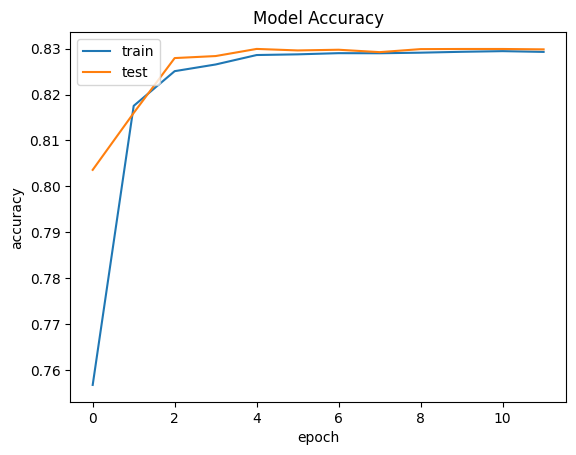

In [45]:
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Gráficas de pérdida y precisión en el entrenamiento

### Pérdida

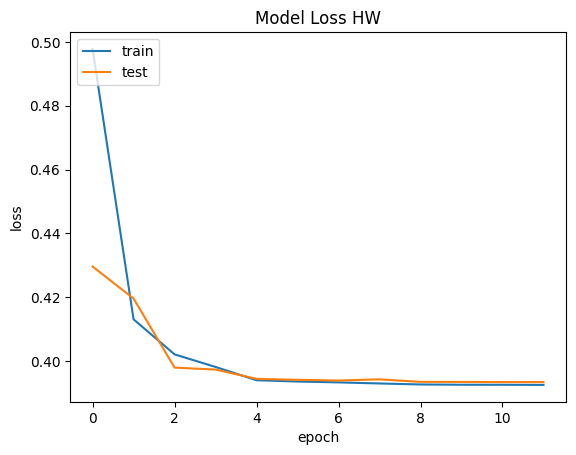

In [49]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss HW')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Precisión

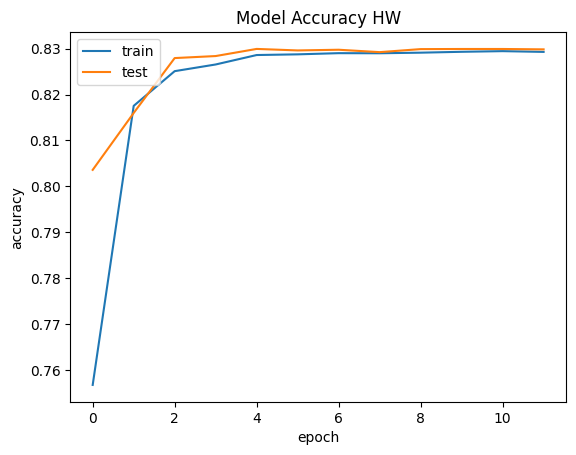

In [51]:
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy HW')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predicciones red MaRu

In [53]:
x_test_tensor = convert_to_tensor(dataset_img_test_array_plana)

1786/1786 [==============================] - 25s 13ms/step
Confusion Matrix
[[39098  3717]
 [ 4976  9344]]
Classification Report
              precision    recall  f1-score   support

    Negative       0.89      0.91      0.90     42815
    Positive       0.72      0.65      0.68     14320

    accuracy                           0.85     57135
   macro avg       0.80      0.78      0.79     57135
weighted avg       0.84      0.85      0.85     57135



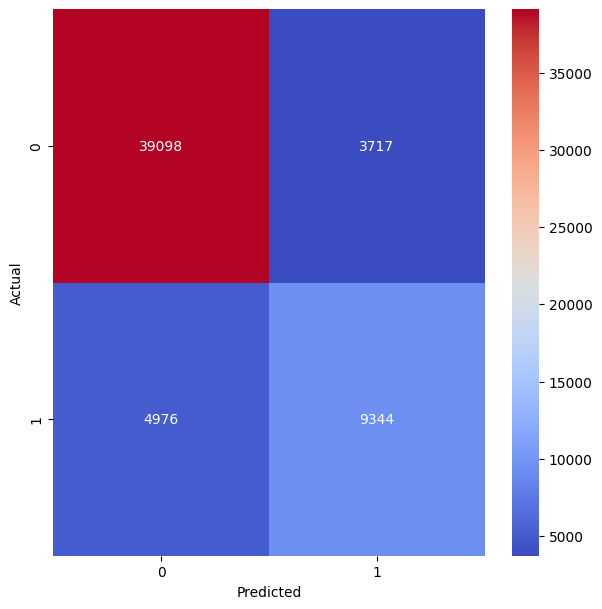

In [54]:
probas_pred = model.predict(x_test_tensor)
Y_pred=[]
for i in probas_pred:
    if i[0]>i[1]:
        Y_pred.append(0)
    else:
        Y_pred.append(1)

print('Confusion Matrix')
print(confusion_matrix(y_test, Y_pred))
print('Classification Report')
print(classification_report(y_test, Y_pred, target_names=['Negative','Positive']))

confusionmatrix1=confusion_matrix(y_test, Y_pred)

classes=[0,1]
con_mat_df = pd.DataFrame(confusion_matrix(y_test, Y_pred),
                     index = classes, 
                     columns = classes)


figure = plt.figure(figsize=(6, 6))
sns.heatmap(con_mat_df, annot=True,cmap='coolwarm',fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()